Video-tutorial in the Youtube channel BioPrograma


In [ ]:
#to reproduce the same environment I used  for this notebook
#conda env create -f cellpose_bruni.yml
'''The dataset used in this notebook can be found here https://bbbc.broadinstitute.org/BBBC014 . 
Recommended citation
"We used image set BBBC014v1 provided by Ilya Ravkin, available from the Broad Bioimage Benchmark Collection [Ljosa et al., Nature Methods, 2012 https://www.nature.com/articles/nmeth.2083]."

Copyright
Creative Commons LicenseThe SBS Bioimage CNT images are licensed under a Creative Commons Attribution 3.0 Unported License by Ilya Ravkin. '''

In [2]:
#import libraries and modules
import os
import glob
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from cellpose import models, io
from skimage.io import imread, imshow, imsave 
import pandas as pd
import re
import seaborn
import numpy as np


In [2]:
os.chdir('add your folder path here')
print(os.getcwd())

C:\Users\bruni\OneDrive\Documents\BioPrograma\0008_cytoplasm_nucleus_translocation


Text(0.5, 1.0, 'NFKappaB')

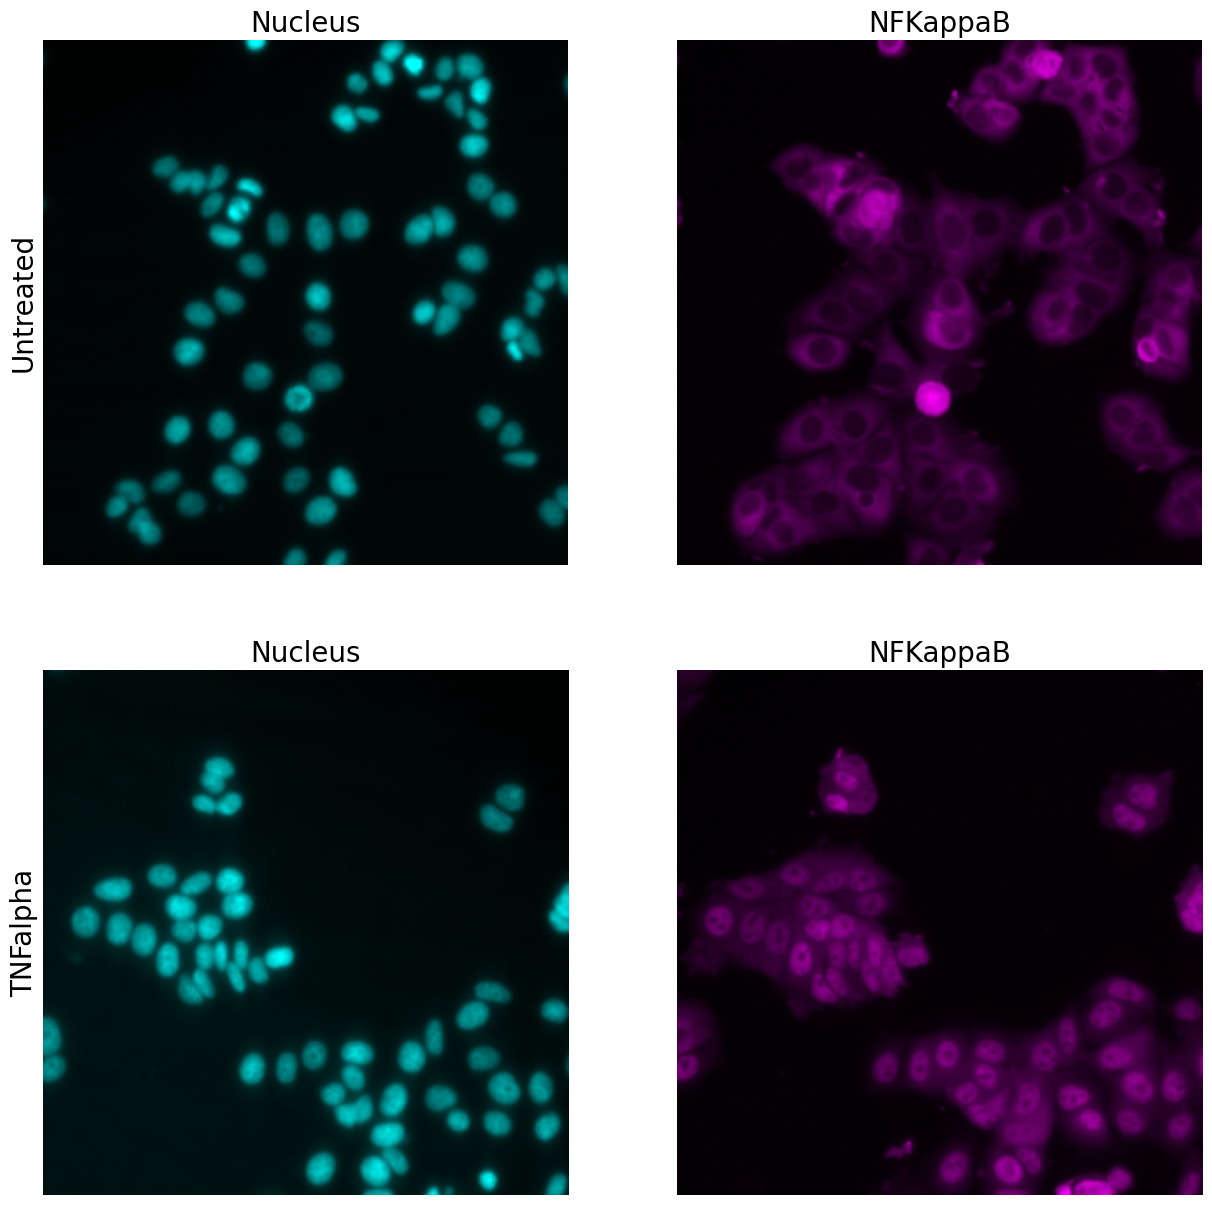

In [3]:
# Load your images
nucleus_untreated = imread("BBBC014_v1_images/Channel 2-48-D-12-00.Bmp")
nfkappab_untreated = imread("BBBC014_v1_images/Channel 1-48-D-12-00.Bmp")
nucleus_TNFalpha = imread("BBBC014_v1_images/Channel 2-27-C-03-00.Bmp")
nfkappab_TNFalpha = imread("BBBC014_v1_images/Channel 1-27-C-03-00.Bmp")

# Define custom colormaps cyan_cmap and magenta_cmap

cyan_cmap = mcolors.LinearSegmentedColormap.from_list("", ["black", "cyan"])
magenta_cmap = mcolors.LinearSegmentedColormap.from_list("", ["black", "magenta"])

# Create the figure and axes
figs, axs = plt.subplots(2, 2, figsize=(15, 15))

# Plot the images and add lateral titles
axs[0, 0].imshow(nucleus_untreated[100:400, 100:400], cmap=cyan_cmap)
axs[0, 0].axis('off')
axs[0, 0].set_title('Nucleus', fontsize=20)
axs[0, 0].text(-0.01,0.5, 'Untreated', rotation=90, va='center', ha='right', fontsize=20, transform=axs[0, 0].transAxes)
axs[0, 1].imshow(nfkappab_untreated[100:400, 100:400], cmap=magenta_cmap)
axs[0, 1].axis('off')
axs[0, 1].set_title('NFKappaB', fontsize=20)
axs[1, 0].imshow(nucleus_TNFalpha[100:400, 100:400], cmap=cyan_cmap)
axs[1, 0].axis('off')
axs[1, 0].set_title('Nucleus', fontsize=20)
axs[1, 0].text(-0.01, 0.5, 'TNFalpha', rotation=90, va='center', ha='right', fontsize=20, transform=axs[1, 0].transAxes)
axs[1, 1].imshow(nfkappab_TNFalpha[100:400, 100:400], cmap=magenta_cmap)
axs[1, 1].axis('off')
axs[1, 1].set_title('NFKappaB', fontsize=20)


# Goal: Generate labels to quantify fluorescence intensity in the nucleus and the cytoplasm
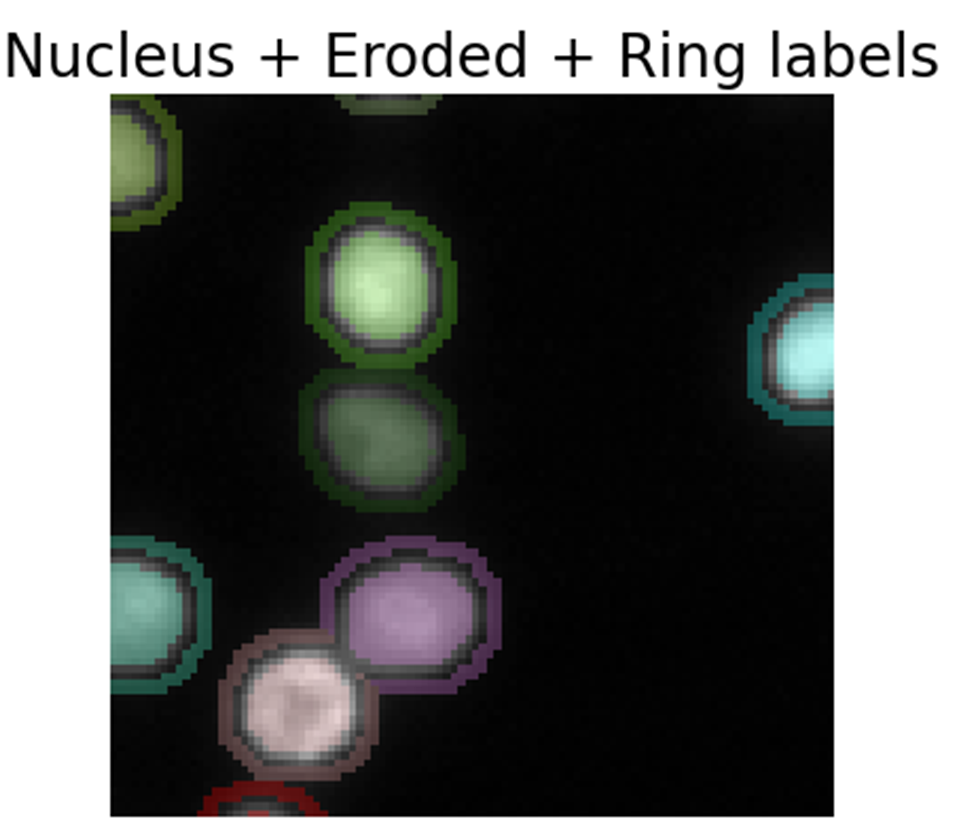

In [4]:
#run cellpose using different names for labels. You can use another segmentation algorithm strategy here (i.e stardist)
model = models.Cellpose(gpu=True, model_type='nuclei') #if you do not have GPU on your computer, use replace True for False in the code
channels = [0,0] # This means we are processing single channel greyscale images for cellpose
label_image, flows, styles, diams = model.eval(nucleus_untreated, flow_threshold=1.0, diameter=20, channels=channels)



In [8]:
#Function random_map by Guilhaume Witz to make a random cmap to label colors. 
#https://github.com/guiwitz/neubias_academy_biapy/blob/master/16-Experiment_analysis.ipynb
#BSD 3-Clause License Copyright (c) 2021, University of Bern, Mathematical Institute and Microscopy Imaging Center, Guillaume Witz
def random_cmap():
    np.random.seed(42)
    cmap = matplotlib.colors.ListedColormap (np.random.rand(256,4))
    # value 0 should just be transparent
    cmap.colors[:,3] = 0.3
    cmap.colors[0,:] = 1
    cmap.colors[0,3] = 0

    # if image is a mask, color (last value) should be red
    cmap.colors[-1,0] = 1
    cmap.colors[-1,1:3] = 0
    return cmap


cmap_label_1 = random_cmap()  
#Cmap_label with black background
def random_cmap():
    np.random.seed(42)
    cmap = mcolors.ListedColormap(np.random.rand(256, 4))
    
    cmap.colors[0, :] = 0  
    cmap.colors[0, 3] = 1  

   
    cmap.colors[-1, 0] = 1  
    cmap.colors[-1, 1:3] = 0  
    return cmap

cmap_label_0 = random_cmap()

In [ ]:

fig, axs = plt.subplots(1, 3, figsize=(15, 15))
axs[0].imshow(nucleus_untreated[100:400, 100:400], cmap='gray')
axs[0].set_title('Nucleus', fontsize=20)
axs[0].axis('off')
axs[1].imshow(label_image[100:400, 100:400], cmap=cmap_label_0)
axs[1].set_title('Label image', fontsize=20)
axs[1].axis('off')
axs[2].imshow(nucleus_untreated[100:400, 100:400], cmap='gray')
axs[2].imshow(label_image[100:400, 100:400], cmap=cmap_label_0)
axs[2].set_title('Nucleus + Label image', fontsize=20)
axs[2].axis('off')


In [6]:
#erode nuclear label and make cytoplasm ring

from skimage import morphology
import pyclesperanto_prototype as cle 
   # Perform a morphological dilation with clesperanto to make cytoplasm label
cyto_label = cle.dilate_labels(label_image, radius=3)
  # Perform a morphological dilation with clesperanto to dilate the nucleus
dilated_nucleus = cle.dilate_labels(label_image, radius=1)
    # Perform a morphological erosion to create the inner ring
   
eroded = morphology.erosion(label_image, morphology.disk(1))

        
    # Subtract the eroded image from the dilated image to get the ring
ring = cyto_label - dilated_nucleus

ring = np.array(ring).astype(int)
eroded = np.array(eroded).astype(int)


(-0.5, 99.5, 99.5, -0.5)

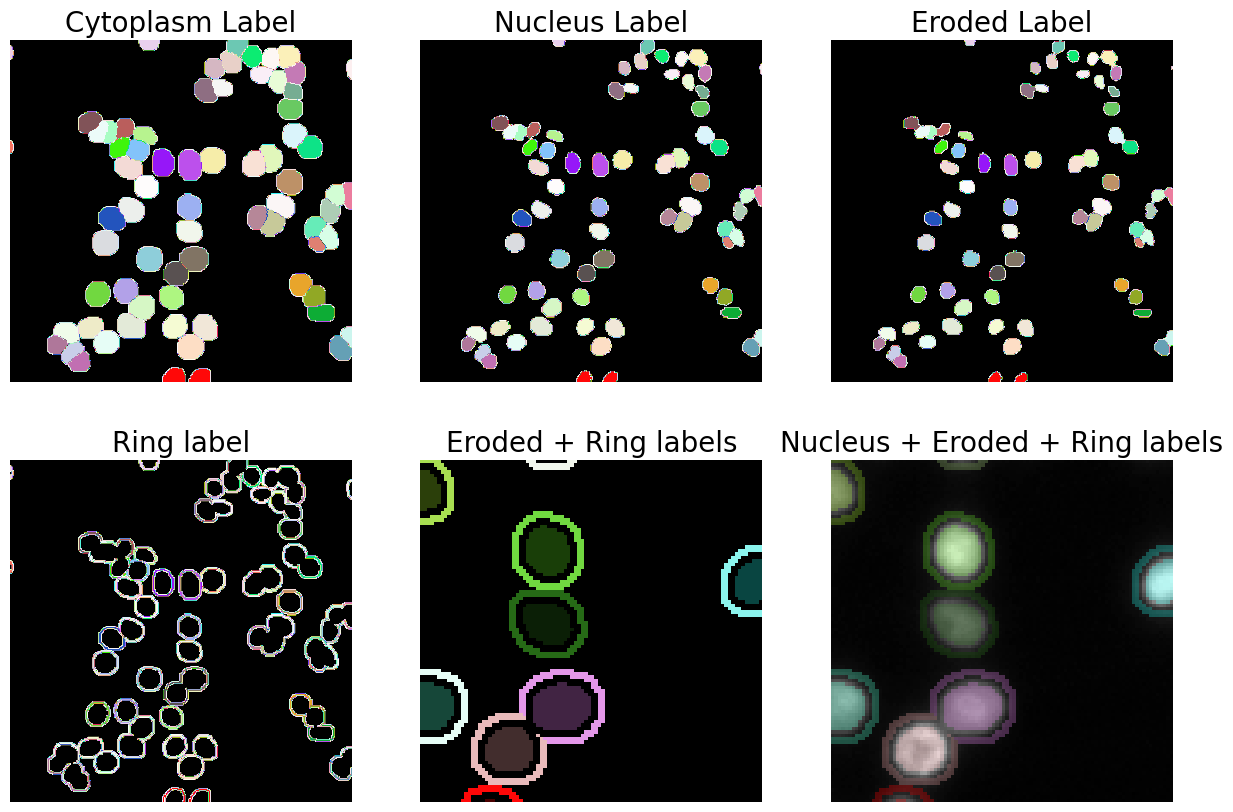

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs[0,0].imshow(cyto_label[100:400, 100:400], cmap=cmap_label_0)
axs[0,0].set_title('Cytoplasm Label', fontsize=20)
axs[0,0].axis('off')
axs[0,1].imshow(label_image[100:400, 100:400], cmap=cmap_label_0)
axs[0,1].set_title('Nucleus Label', fontsize=20)
axs[0,1].axis('off')
axs[0,2].imshow(eroded[100:400, 100:400], cmap=cmap_label_0)
axs[0,2].set_title('Eroded Label', fontsize=20)
axs[0,2].axis('off')
axs[1,0].imshow(ring[100:400, 100:400], cmap=cmap_label_0)
axs[1,0].set_title('Ring label', fontsize=20)
axs[1,0].axis('off')
axs[1,1].imshow(ring[220:320, 220:320], cmap=cmap_label_0)
axs[1,1].imshow(eroded[220:320, 220:320], cmap=cmap_label_1)
axs[1,1].set_title('Eroded + Ring labels', fontsize=20)
axs[1,1].axis('off')
axs[1,2].imshow(nucleus_untreated[220:320, 220:320], cmap='gray')
axs[1,2].imshow(ring[220:320, 220:320], cmap=cmap_label_1)
axs[1,2].imshow(eroded[220:320, 220:320], cmap=cmap_label_1)
axs[1,2].set_title('Nucleus + Eroded + Ring labels', fontsize=20)
axs[1,2].axis('off')

In [10]:
#run morphology and save dafaframe as csv - data wrangling para adquirir a razao
from skimage.measure import regionprops_table

results_ring = regionprops_table(ring, intensity_image= nfkappab_untreated, properties= ('label','mean_intensity'))
results_eroded = regionprops_table(eroded, intensity_image= nfkappab_untreated, properties= ('label','mean_intensity'))



In [11]:
#Make dataframe
df_results_ring = pd.DataFrame(results_ring)
df_results_eroded = pd.DataFrame(results_eroded)
df_results_eroded['NFKappaB nucleus/cyto']  =  df_results_eroded['mean_intensity'] / df_results_ring['mean_intensity']

#rename mean_intensity column
df_results_eroded.rename(columns={'mean_intensity': "NFKappaB nuclear intensity"}, inplace=True)
df_results_eroded

,label,NFKappaB nuclear intensity,NFKappaB nucleus/cyto
0,1,97.620000,1.267253
1,2,31.734177,0.692980
2,3,42.388889,0.935859
3,4,61.613445,0.806866
4,5,33.402913,0.842596
...,...,...,...
659,660,41.375000,0.752737
660,661,101.354430,0.652715
661,662,63.309524,0.780675
662,663,32.589744,0.617188


# Automation for  Cellpose segmentation  and translocation (nucleus/cytoplasm ratios)

In [57]:
'''The code for retrieving file information about conditions and replicated was based on #https://github.com/guiwitz/neubias_academy_biapy/blob/master/16-Experiment_analysis.ipynb
#BSD 3-Clause License Copyright (c) 2021, University of Bern, Mathematical Institute and Microscopy Imaging Center, Guillaume Witz'''

from skimage import morphology, io, measure
import pyclesperanto_prototype as cle
import glob
import re
import pandas as pd
import numpy as np
import cellpose.models as models

target_files = np.sort(glob.glob('BBBC014_v1_images/*Channel 1*.Bmp'))
nucleo_files = np.sort(glob.glob('BBBC014_v1_images/*Channel 2*.Bmp'))

# Load the cellpose model and adjust cellpose parameters (i.e channels = [0, 0], flow_threshold = 1.0, diameter = 20.0)
model = models.Cellpose(gpu=True, model_type='nuclei')  # if no GPU, set gpu=False
channels = [0, 0]  # Processing single channel greyscale images for cellpose
flow_threshold = 1.0
diameter = 20.0
# Parameters to measure with properties
properties = ['label', 'mean_intensity']  
# List to contain the dataframes with the results
results_eroded = []  
results_ring = []

# Set disk size and radius sizes for label erosion and dilation 
disk_1 = morphology.disk(2.0)
radius_cyto = 3
radius_dilated_nucleus = 1

# For loop for running nuclear segmentation, generation of eroded and ring labels and quantification
for i, (nucleo_file, target_file) in enumerate(zip(nucleo_files, target_files)):
    #load files with nuclear staining
    nucleo_ch1 = io.imread(nucleo_file)
    #cellpose segmentation
    label_image, flows, styles, diams = model.eval(nucleo_ch1, flow_threshold=flow_threshold, diameter=diameter, channels=channels)
   
    #generate pseudo cytoplasm label
    cyto_label = cle.dilate_labels(label_image, radius=radius_cyto)
    #generate dilated nucleus label
    dilated_nucleus = cle.dilate_labels(label_image, radius=radius_dilated_nucleus)
    #shrink (erode) the nuclear label
    eroded = morphology.erosion(label_image, disk_1)
    #generate ring label
    ring = cyto_label - dilated_nucleus
    #convert labels from float to int so it can be measured with skimage.measure.regionprops_table
    ring = np.array(ring).astype(int)
    eroded = np.array(eroded).astype(int) 
    #load files with fluorescent channel to be measured
    target_ch1 = io.imread(target_file)
    #perform measurements
    data_eroded = measure.regionprops_table(eroded, intensity_image=target_ch1, properties=properties)
    data_ring = measure.regionprops_table(ring, intensity_image=target_ch1, properties=properties)
    #convert skimage.measure.regionprops_table output (a dictionary) into pandas DataFrame
    df_results_eroded = pd.DataFrame(data_eroded)
    df_results_ring = pd.DataFrame(data_ring)

    '''we need to get the ids of each image. Get this info from the file names.
    Get the replicate (rep1, rep2, etc)  and get conditions (control or treated, for example)'''
    filename = target_file.split('\\')[1]
    condition = re.findall('.* .*-.*-.*-(.*)-.*.Bmp', filename)[0]
    technical_replicate = re.findall('.* .*-.*-(.*)-.*-.*.Bmp', filename)[0]

    df_results_eroded['filename'] = filename
    df_results_eroded['condition'] = condition
    df_results_eroded['technical_replicate'] = technical_replicate
    #append dataframes into a single one
    results_eroded.append(df_results_eroded)
    results_ring.append(df_results_ring)

#data wrangling to cancatanate dataframes
df_results_eroded = pd.concat([df.reset_index(drop=True) for df in results_eroded], ignore_index=True)
df_results_ring = pd.concat([df.reset_index(drop=True) for df in results_ring], ignore_index=True)

# Calculate the ratio directly on the DataFrame
df_results_eroded['NFKappaB_nuc_cyto_ratio'] = df_results_eroded['mean_intensity'] / df_results_ring['mean_intensity']

In [58]:
df_results_eroded

,label,mean_intensity,filename,condition,technical_replicate,NFKappaB_nuc_cyto_ratio
0,1,93.800000,Channel 1-01-A-01-00.Bmp,01,A,1.573323
1,2,119.066667,Channel 1-01-A-01-00.Bmp,01,A,2.767042
2,3,90.051852,Channel 1-01-A-01-00.Bmp,01,A,3.100097
3,4,93.625806,Channel 1-01-A-01-00.Bmp,01,A,2.219069
4,5,135.298246,Channel 1-01-A-01-00.Bmp,01,A,1.520838
...,...,...,...,...,...,...
41628,660,39.927083,Channel 1-48-D-12-00.Bmp,12,D,0.451406
41629,661,98.637931,Channel 1-48-D-12-00.Bmp,12,D,2.113670
41630,662,59.646154,Channel 1-48-D-12-00.Bmp,12,D,0.953695
41631,663,27.750000,Channel 1-48-D-12-00.Bmp,12,D,0.458808


<AxesSubplot: xlabel='condition', ylabel='NFKappaB_nuc_cyto_ratio'>

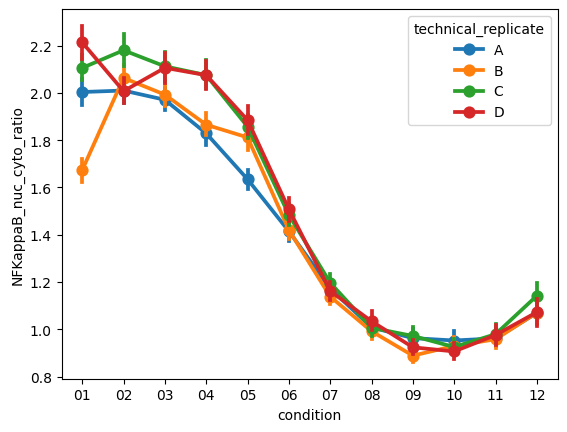

In [62]:
#plot a graph using seaborn
import seaborn as sns
sns.pointplot(data=df_results_eroded, x='condition', y='NFKappaB_nuc_cyto_ratio', hue='technical_replicate')
